# BERT

In [33]:
import pandas as pd
from underthesea import word_tokenize, text_normalize

# Data Preprocessing

In [34]:
df = pd.read_csv('facebook_comment_2k7.csv')
df.head()

,Unnamed: 0,id,text,label
0,0,3113b477-4ea3-4c3f-82d7-6ae6b8c12a3b,Noi cho biet k rãnh viet voi loai ng nhu chị c...,['harassment']
1,1,de5cf256-3879-413d-9e33-2c3be7e2e0c1,-Giải ngân cực nhanh\n-mức vay lên đến 15tr\n👉...,['dangerous_content']
2,2,975a369c-acc2-487c-84dd-64a4764203cf,Thủ tục đơn giản đăng ký khoản vay giải ngân l...,['dangerous_content']
3,3,45aa9b39-c58a-4c91-941a-fe6373d009f5,săn mãi con đen v5 cả tối k đc an ủi đc con be...,['normal']
4,4,99f6d7e6-b1c0-4849-9430-c60137737ead,zalo 0375841653 ae nào mua kết bạn zalo đặt hà...,['dangerous_content']


In [35]:
df = df.drop(['Unnamed: 0', 'id'], axis=1)
df.head()

,text,label
0,Noi cho biet k rãnh viet voi loai ng nhu chị c...,['harassment']
1,-Giải ngân cực nhanh\n-mức vay lên đến 15tr\n👉...,['dangerous_content']
2,Thủ tục đơn giản đăng ký khoản vay giải ngân l...,['dangerous_content']
3,săn mãi con đen v5 cả tối k đc an ủi đc con be...,['normal']
4,zalo 0375841653 ae nào mua kết bạn zalo đặt hà...,['dangerous_content']


In [36]:
print(df.shape)

(2700, 2)


Đối với những sample có 2 label trở lên thì tách thành các sample riêng chỉ với 1 label

In [37]:
import ast

df['label'] = df['label'].apply(ast.literal_eval) # convert string to list
df  = df.explode('label')
df.head()

,text,label
0,Noi cho biet k rãnh viet voi loai ng nhu chị c...,harassment
1,-Giải ngân cực nhanh\n-mức vay lên đến 15tr\n👉...,dangerous_content
2,Thủ tục đơn giản đăng ký khoản vay giải ngân l...,dangerous_content
3,săn mãi con đen v5 cả tối k đc an ủi đc con be...,normal
4,zalo 0375841653 ae nào mua kết bạn zalo đặt hà...,dangerous_content


In [38]:
print(df.shape)

(2790, 2)


In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

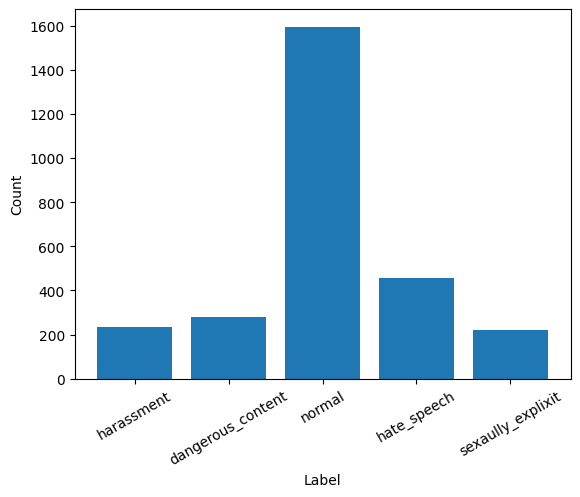

In [40]:
from collections import Counter
from matplotlib import pyplot as plt

label_count = Counter(df['label'])
plt.bar(label_count.keys(), label_count.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

In [41]:
print(label_count)

Counter({'normal': 1595, 'hate_speech': 456, 'dangerous_content': 281, 'harassment': 236, 'sexaully_explixit': 222})


In [42]:
def preprocess_text(text):
    text = text_normalize(text)
    return text
    
df['text'] = df['text'].apply(preprocess_text)

df.head()

,text,label
0,Noi cho biet k rãnh viet voi loai ng nhu chị c...,harassment
1,- Giải ngân cực nhanh - mức vay lên đến 15 tr ...,dangerous_content
2,Thủ tục đơn giản đăng ký khoản vay giải ngân l...,dangerous_content
3,săn mãi con đen v5 cả tối k đc an ủi đc con be...,normal
4,zalo 0375841653 ae nào mua kết bạn zalo đặt hà...,dangerous_content


https://huggingface.co/keepitreal/vietnamese-sbert

In [43]:
from sentence_transformers import SentenceTransformer

# model = SentenceTransformer('keepitreal/vietnamese-sbert')

https://huggingface.co/bkai-foundation-models/vietnamese-bi-encoder

In [79]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bkai-foundation-models/vietnamese-bi-encoder')

maps sentences & paragraphs to a 768 dimensional dense vector space

In [80]:
X_train = model.encode(X_train.values)
X_test = model.encode(X_test.values)

Tìm model tốt nhất với các param

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Define the parameter grids for each model
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Define the dictionary of models with their corresponding parameter grids
models = {
    "Logistic Regression": (LogisticRegression(), param_grid_lr),
    "Decision Tree Classifier": (DecisionTreeClassifier(), param_grid_dt),
    "Random Forest Classifier": (RandomForestClassifier(), param_grid_rf),
    "SVC": (SVC(), param_grid_svc)
}

# Perform GridSearchCV for each model
best_models = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_

In [47]:
print(best_models)

{'Logistic Regression': LogisticRegression(C=0.1, solver='liblinear'), 'Decision Tree Classifier': DecisionTreeClassifier(max_depth=10, min_samples_leaf=4), 'Random Forest Classifier': RandomForestClassifier(n_estimators=50), 'SVC': SVC(C=10, gamma='auto')}


In [48]:
for name, model in best_models.items():
    # model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))

Model: Logistic Regression
                   precision    recall  f1-score   support

dangerous_content       0.98      0.80      0.88        59
       harassment       0.82      0.27      0.41        52
      hate_speech       0.59      0.65      0.62        83
           normal       0.81      0.95      0.88       325
sexaully_explixit       0.73      0.41      0.52        39

         accuracy                           0.79       558
        macro avg       0.79      0.61      0.66       558
     weighted avg       0.79      0.79      0.77       558

Model: Decision Tree Classifier
                   precision    recall  f1-score   support

dangerous_content       0.61      0.66      0.63        59
       harassment       0.15      0.12      0.13        52
      hate_speech       0.34      0.36      0.35        83
           normal       0.75      0.77      0.76       325
sexaully_explixit       0.22      0.18      0.20        39

         accuracy                           0.59   

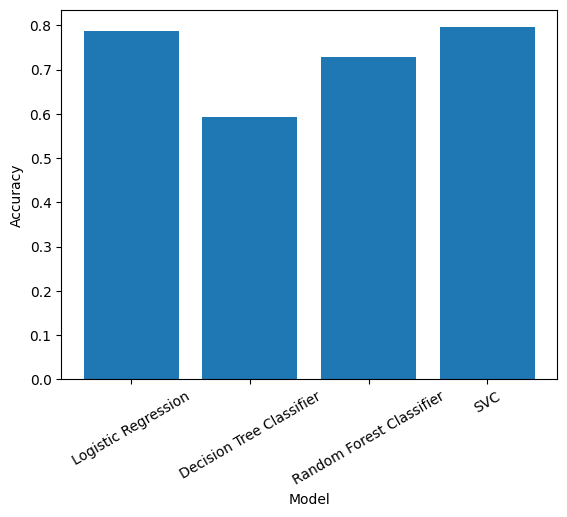

In [51]:
from matplotlib import pyplot as plt

models_accuracy = {name: model.score(X_test, y_test) for name, model in best_models.items()}
plt.bar(models_accuracy.keys(), models_accuracy.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=30)
plt.show()

Modal default không set các param

In [49]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "SVC": SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))

Model: Logistic Regression
                   precision    recall  f1-score   support

dangerous_content       0.92      0.80      0.85        59
       harassment       0.38      0.27      0.31        52
      hate_speech       0.51      0.59      0.54        83
           normal       0.85      0.90      0.88       325
sexaully_explixit       0.58      0.46      0.51        39

         accuracy                           0.75       558
        macro avg       0.65      0.60      0.62       558
     weighted avg       0.75      0.75      0.75       558

Model: Decision Tree Classifier
                   precision    recall  f1-score   support

dangerous_content       0.59      0.69      0.64        59
       harassment       0.15      0.15      0.15        52
      hate_speech       0.34      0.35      0.35        83
           normal       0.77      0.73      0.75       325
sexaully_explixit       0.24      0.26      0.25        39

         accuracy                           0.58   

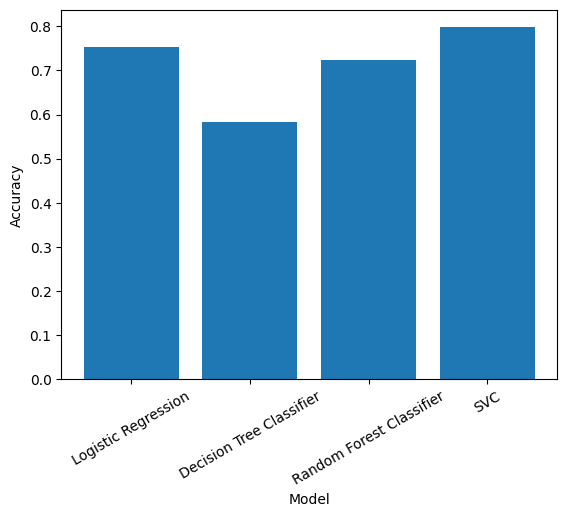

In [52]:
from matplotlib import pyplot as plt

models_accuracy = {name: model.score(X_test, y_test) for name, model in models.items()}
plt.bar(models_accuracy.keys(), models_accuracy.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=30)
plt.show()